In [1]:
import pandas as pd
import numpy as np

import autogluon
from autogluon.text import TextPredictor

from catboost import CatBoostClassifier
import fasttext
import gensim
import gensim.downloader as gensim_api
from gensim.models import Word2Vec, FastText
from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
nltk.download('stopwords')

from pymorphy2 import MorphAnalyzer
import pickle
import re
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import preprocessing

from string import punctuation

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification

from tabulate import tabulate
from tqdm import trange
import random

import warnings
warnings.filterwarnings('ignore')

2022-06-23 13:08:52.944502: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-23 13:08:52.944524: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to /home/nlp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_train = pd.read_csv('data/df_train.csv')
df_test = pd.read_csv('data/df_test.csv')

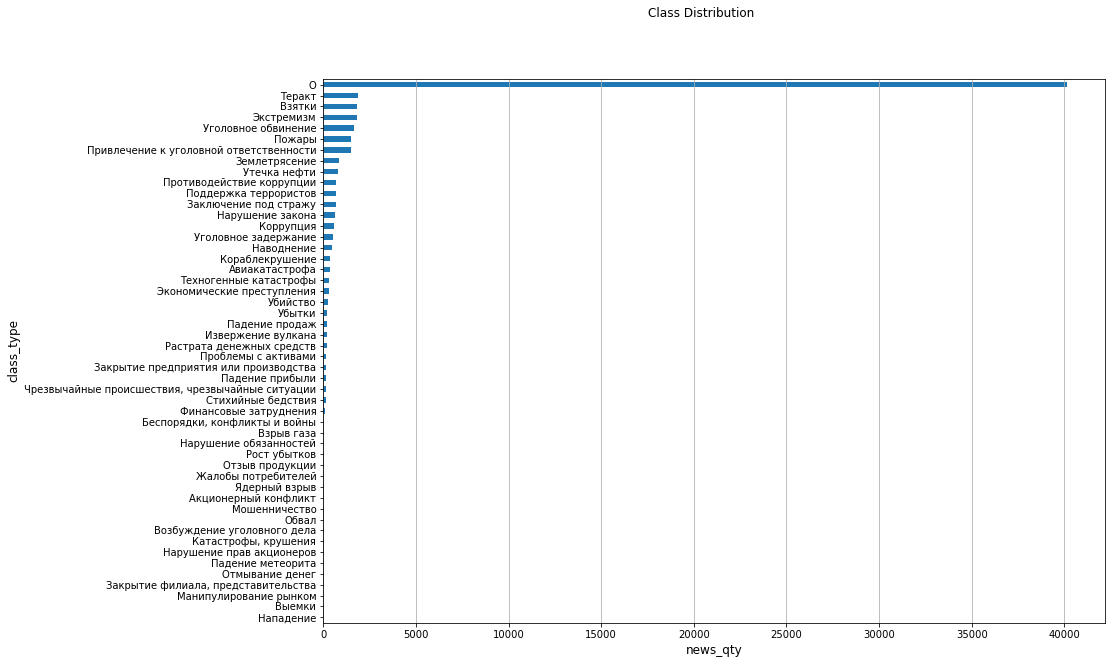

In [3]:
fig, ax = plt.subplots()
fig.suptitle("Class Distribution", fontsize=12)
ax.set_xlabel('news_qty', fontsize=12)
ax.set_ylabel('class_type',fontsize=12)
df_train['class'].value_counts(ascending=True).plot(by='index', kind='barh', ax=ax, figsize=(14,10),fontsize=10).grid(axis='x')
plt.show()

In [4]:
df_train['class'].value_counts()

O                                                   40159
Теракт                                               1898
Взятки                                               1801
Экстремизм                                           1798
Уголовное обвинение                                  1634
Пожары                                               1510
Привлечение к уголовной ответственности              1475
Землетрясение                                         841
Утечка нефти                                          816
Противодействие коррупции                             707
Поддержка террористов                                 702
Заключение под стражу                                 694
Нарушение закона                                      636
Коррупция                                             599
Уголовное задержание                                  517
Наводнение                                            489
Кораблекрушение                                       378
Авиакатастрофа

In [5]:
len(df_train['class'].value_counts())

50

### Subtotal 1
Classes are unbalanced. There are various methods for processing unbalanced data. We will highlight the main ones:
- over-sampling - the most naive strategy is to generate new samples by randomly sampling with replacement the current available samples;
- under-sampling - this method is randomly selecting a subset of data for the targeted classes; in other words, all classes in balanced proportions are selected from the original data set, that is, some data, in principle, may not be included in the final data set;

Since in our data one class is more than 60 % of the total, we'll use over-samling method (generate a large amount of synthetic data to complete class balancing) in several path in this project. We'll focus on the stratification of classes as well.

# Help Functions

In [231]:
'''Additional stopwords'''
sw = ['всё', 'тому', 'представьте', 'чьё', 'смысле', 'статься', 'знаешь', 'получается', 'или', 'выяснилось', 'удивительно',
      'которых', 'оти', 'значится', 'сказано', 'никогда', 'об', 'образом', 'моему', 'самом', 'свыше', 'во-вторых', 'как', 'чья', 'иметь', 
      'следовательно', 'серьезно', 'точки', 'точнее', 'поди', 'бы', 'но', 'само', 'осле', 'конено', 'около', 'из-за', 'отому', 'скажем',
      'новость', 'достаточно', 'издревле', 'когда', 'любом', 'ваша', 'мол', 'конец', 'словно', 'никто', 'уж', 'да', 'актуальный', 'попросту',
      'бесспорно', 'долженствовать', 'было', 'которая', 'хорошо', 'случайно', 'хоть', 'ко', 'видать', 'повседневной', 'этот', 'позволь',
      'наверно', 'прочему', 'самым', 'буквально', 'здесь' 'воистину', 'право', 'ничего', 'понятно', 'разнообразный', 'вообразите', 'июль',
      'эта', 'тогда', 'дальше', 'конечно', 'наоборот', 'бывает', 'твоя', 'мне', 'полагать', 'важно', 'нам', 'представленный', 'проще',
      'очередной', 'выясняется', 'странно', 'устоявшееся', 'моя', 'всевозможный', 'долженствующий', 'прочий', 'где', 'откровенно', 'принято',
      'беспрецедентный', 'целом', 'один', 'нашей', 'абсолютно', 'следствие', 'также', 'они', 'после', 'согласиться', 'реальный', 'по-твоему',
      'имеется', 'лет', 'небось', 'казалось', 'своему', 'скорее', 'неизгладимый', 'напротив', 'март', 'наверняка', 'обычно', 'нынче',
      'моей', 'примечательно', 'против', 'наконец', 'так', 'тыс', 'какой', 'много', 'ней', 'если', 'должно', 'ваш', 'нее', 'быть', 'этом',
      'чем', 'возможно', 'вестимо', 'знать', 'вроем', 'выражаясь', 'одним', 'теерь', 'кажется', 'многие', 'от', 'есть', 'себе', 'просто',
      'всяком', 'даже', 'ничто', 'обычаю', 'знает', 'исходя', 'несколько', 'предельно', 'ли', 'она', 'ерез', 'вас', 'ведь', 'имеются', 'более',
      'он', 'кто', 'по', 'уть', 'свою' 'твоему', 'них', 'кстати', 'од', 'крайне', 'ри', 'говори', 'примеру', 'их', 'вашему', 'всякого',
      'исключение', 'через', 'того', 'год', 'оказывается', 'по-ихнему', 'вишь', 'конце', 'вашего', 'тоб', 'кб', 'пожалуйста', 'сейас',
      'вам', 'эй', 'над', 'естественно', 'без', 'нибудь', 'нечего', 'еред', 'куда', 'вообще-то', 'менее', 'по-вашему', 'хм', 'что', 'про',
      'всей', 'им', 'наша', 'кажись', 'твоего', 'своей', 'наверное', 'собой', 'нами', 'предположительно', 'мы', 'всех', 'по-моему', 'исстари',
      'себя', 'некто', 'иногда', 'совершенно', 'для', 'вы', 'этих', 'как-то', 'разумеется', 'ему', 'всегда', 'чего', 'другие', 'во-первых',
      'позвольте', 'вип', 'очевидно', 'так-то', 'замыслу', 'нарочно', 'короче', 'то', 'помилуйте', 'сути', 'по-хорошему', 'иначе', 'нередко',
      'чтобы', 'всего', 'все', 'надо', 'весь', 'раз', 'известно', 'из', 'свой', 'по-видимому', 'тут', 'под', 'мой', 'ул', 'луше', 'ей', 'только',
      'вероятно', 'видимо', 'руб', 'слову', 'нет', 'за', 'тем', 'во', 'например', 'помимо', 'такой', 'будет', 'помилуй', 'тоже', 'скажут',
      'видно', 'пожалуй', 'общеизвестно', 'чье', 'вдобавок', 'впрочем', 'соответственно', 'зачастую', 'сам', 'том', 'там', 'полагается',
      'меня', 'однако', 'слышь', 'итак', 'подобное', 'действительно', 'еще', 'его', 'наше', 'данный', 'твой', 'ай', 'необходимо', 'три',
      'далее', 'тот', 'эм', 'же', 'жаль', 'другими', 'видишь', 'некоторых', 'прежде', 'который', 'допустим', 'положено', 'по-нашему', 'весьма',
      'не', 'ро', 'той', 'этого', 'эти', 'напомним', 'правда', 'выходит', 'перед', 'определенно', 'какая', 'относительно', 'сразу', 'имя',
      'чей', 'ее', 'отом', 'неё', 'это', 'два', 'эту', 'разве', 'вне', 'тобы', 'знамо', 'всем', 'вернее', 'будто', 'вновь', 'которые', 'данным',
      'кроме', 'таким', 'нечто', 'кого', 'больше', 'ом', 'уже', 'прочего', 'очень', 'при', 'те', 'вообще', 'ясно', 'ну', 'октябрь', 'до',
      'на', 'в-третьих', 'ежели', 'общем', 'ещё', 'похоже', 'ибо', 'оно', 'ты', 'сверх', 'значит', 'безусловно', 'правильнее', 'ниего', 'него', 'совсем',
      'вами', 'общем-то', 'всю', 'наш', 'всему', 'всякий', 'ой', 'этой', 'ни', 'со', 'вот', 'день', 'может', 'мб', 'тебя', 'нас',
      'оять', 'хотя', 'прочим', 'этим', 'между', 'ним', 'вероятнее', 'бывало', 'примерно', 'вдруг', 'либо']

'''Function for normalizing text'''
def preprocess_text(txt: str, sw = []) -> str:
    exclude = list(punctuation)
    '''Stopwords from nltk'''
    sw_1 = list(stopwords.words('russian'))
    morpher = MorphAnalyzer()
    txt = str(txt)
    '''Bringing to lower case, removal of stopwords, punctuation marks, latin letters and numbers'''
    tokenizer = RegexpTokenizer('\w+|[^\w\s]+')
    txt = [i.lower() for i in tokenizer.tokenize(txt) if i not in exclude and i not in sw and i not in sw_1 and len(i) > 2 and \
           re.search('\)|\(|\.|\:|\;|\!|\?|\<|\>', i) is None]
    #      re.search('(\d+)|\)|\(|\.|\:|\;|\!|\?|\<|\>|[A-Za-z]', i) is None]
    '''Lemmatization'''
    txt = [morpher.parse(word)[0].normal_form for word in txt]
    return ' '.join(txt)

def count_metrics(y_test, y_pred):
    metrics = {}
    metrics['accuracy'] = round(accuracy_score(y_test, y_pred), 3)
    metrics['f1_weighted'] = round(f1_score(y_test, y_pred, pos_label='positive', average='weighted'), 3)
    metrics['precision'] = round(precision_score(y_test, y_pred, pos_label='positive', average='weighted'), 3)
    metrics['recall'] = round(recall_score(y_test, y_pred, pos_label='positive', average='weighted'), 3)
    return metrics

def display_metrics(y_test, y_pred, name, data_metrics):
    metrics_rf = count_metrics(y_test, y_pred)
    data_metrics[name] = pd.Series(metrics_rf)
    return(display(data_metrics))

# Text Normalization

In [48]:
'''Let's normalize text data'''
train_norm = df_train.copy()
train_norm['text'] = train_norm.apply(lambda x: preprocess_text(x['text'], sw), axis=1)

test_norm = df_test.copy()
test_norm['text'] = test_norm.apply(lambda x: preprocess_text(x['text'], sw), axis=1)

In [4]:
train_norm = pd.read_csv('data/train_norm_1.csv')
test_norm = pd.read_csv('data/test_norm_1.csv')

# Imbalanced Data

In [5]:
def get_resampled_data(df):
    tokenizer = RegexpTokenizer("\w+|[^\w\s]+")
    
    X = (df['text'].values).reshape(-1, 1)
    y = (df['class'].values).reshape(-1, 1)

    ros = RandomOverSampler(random_state=42)

    X_resampled, y_resampled = ros.fit_resample(X, y)
    X_resampled = np.array([i for j in X_resampled for i in j])

    return X_resampled, y_resampled

In [6]:
# resampled data for raw text data
X_resampled, y_resampled = get_resampled_data(df_train)

# resampled data for normalized text data
X_resampled_norm, y_resampled_norm = get_resampled_data(train_norm)

# Models Based on Embeddings (without Over-Sampling)

### Class Stratification
Let's use stratified K-Folds cross-validator. It provides train/test indices to split data in train/test sets.
This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In other words, it is necessary that unbalanced classes are distributed evenly as a percentage of the train and test data.

In [7]:
tokenizer = RegexpTokenizer("\w+|[^\w\s]+")

X = (train_norm['text'].values)
y = (train_norm['class'].values)

In [8]:
df_ft = pd.DataFrame()
df_ft['text'] = X
df_ft['class'] = y

df_ft['text'] = [tokenizer.tokenize(i) if isinstance(i, str) else [] for i in df_ft['text'].tolist()]

In [9]:
df_ft

,text,class
0,"[при, продолжать, кудрин, лично, уверенный, на...",O
1,"[сотрудник, отдел, хранить, информация, работн...",O
2,"[сирийский, служба, безопасность, пока, справл...",O
3,"[мвд, сообщить, днк, мужчина, совпасть, образе...",O
4,"[сообщить, среда, пресс, секретарь, белый, дом...",O
...,...,...
59995,"[представлять, тяжело, находиться, беларусь, п...",O
59996,"[рамка, возбудить, уголовный, дело, дать, прав...",O
59997,"[заявить, руководитель, национальный, централь...",O
59998,"[ранее, лайф, рассказывать, тёмный, дело, мушв...",O


In [10]:
X = np.array(df_ft['text'])
y = np.array(df_ft['class'])

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [    0     1     2 ... 59996 59997 59999] TEST: [    3     7     9 ... 59986 59995 59998]
TRAIN: [    2     3     4 ... 59995 59997 59998] TEST: [    0     1     6 ... 59988 59996 59999]
TRAIN: [    0     1     2 ... 59997 59998 59999] TEST: [   11    18    19 ... 59990 59991 59994]
TRAIN: [    0     1     2 ... 59997 59998 59999] TEST: [    4     5     8 ... 59985 59987 59989]
TRAIN: [    0     1     3 ... 59996 59998 59999] TEST: [    2    17    23 ... 59992 59993 59997]


### Fast Text Embeddings
An embedding is a mapping of a discrete - categorical - variable to a vector of continuous numbers.

If we compare the Word2Vec and Fast Text embeddings and the results of the models (random forest, catboost) built on them, then the best results were shown by Fast Text. Fast Text is also able to select the context of the word using various forms of the control word - Word2Vec does not have this. So we'll use the Fast Text to build the embeddings.

In [12]:
# train the fasttext model
ft_emb_model = FastText(X_train, vector_size=100, window=5, min_count=5, workers=4, sg=1)

In [13]:
# save the fast text model
pickle.dump(ft_emb_model, open('models/ft_emb_model.sav', 'wb'))
ft_emb_model = pickle.load(open('models/ft_emb_model.sav', 'rb'))

In [14]:
'''Check the context by the control word (CBOW method)'''
ft_emb_model.wv.most_similar('взятки')

[('взятка', 0.9763526916503906),
 ('посредник', 0.8277751803398132),
 ('взятие', 0.8212900757789612),
 ('взяточник', 0.8196711540222168),
 ('взяткодатель', 0.8033660650253296),
 ('291', 0.802096962928772),
 ('290', 0.8020743727684021),
 ('взяточничество', 0.7979118824005127),
 ('посредничество', 0.7767929434776306),
 ('292', 0.7714999318122864)]

In [ ]:
'''Transform our text data into the embedding'''
words = set(ft_emb_model.wv.index_to_key)
X_train_vect = np.array([np.array([ft_emb_model.wv[i] for i in ls if i in words]) for ls in X_train])
X_test_vect = np.array([np.array([ft_emb_model.wv[i] for i in ls if i in words]) for ls in X_test])

In [18]:
'''Note that the lengths of the word vectors don't coincide with the lengths of the words themselves'''
for i, v in enumerate(X_train_vect):
    print(len(X_train[i]), len(v))
    if i > 10:
        break

15 13
18 18
9 9
11 11
5 4
7 5
9 9
7 5
21 20
13 13
16 16
19 19
7 7
17 16
5 5
10 10
18 17
6 6
6 6
16 16
7 6
3 3
11 10
6 6
16 15
5 5
11 7
11 10
11 11
11 9
12 12
22 22
21 21
10 10
20 16
9 9
25 24
8 7
14 12
9 9
8 8
7 4
6 6
20 20
12 11
16 16
8 8
2 1
8 8
6 6
6 6
15 15
6 6
20 18
14 13
12 12
12 12
8 8
8 6
3 3
11 9
7 6
9 9
7 6
7 5
3 3
6 5
17 17
13 12
7 7
14 13
18 17
14 13
8 8
15 15
15 13
3 3
4 3
22 19
10 10
10 9
12 12
17 17
23 22
22 20
14 14
25 24
5 3
26 25
12 8
12 12
15 15
12 11
20 18
8 6
13 12
31 31
22 21
8 8
11 10
9 8
8 7
7 7
12 12
16 16
16 16
5 4
7 7
9 9
16 13
20 17
6 6
7 5
16 15
8 8
19 15
13 13
8 8
20 20
16 13
11 11
8 7
11 11
11 10
14 14
8 8
21 18
12 12
3 3
11 10
12 11
9 9
7 7
7 6
15 15
7 6
26 25
20 19
17 17
7 7
7 6
17 16
17 17
5 5
8 6
3 3
41 35
11 11
18 15
15 15
17 16
17 17
18 17
21 19
22 18
9 8
16 13
9 9
14 13
6 6
4 3
21 21
16 16
9 9
18 17
15 13
10 10
10 10
7 7
14 14
16 16
20 18
8 8
21 18
4 4
8 8
10 10
22 22
7 7
21 19
5 4
18 16
15 15
16 13
23 23
5 5
19 19
8 5
12 12
9 8
5 5
11 11
10 9
17 1

In [16]:
'''Compute sentence vectors by averaging the word vectors for the words contained in the sentence'''
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

In [20]:
for i, v in enumerate(X_train_vect_avg):
    print(len(X_train[i]), len(v))
    if i > 10:
        break

15 100
18 100
9 100
11 100
5 100
7 100
9 100
7 100
21 100
13 100
16 100
19 100
7 100
17 100
5 100
10 100
18 100
6 100
6 100
16 100
7 100
3 100
11 100
6 100
16 100
5 100
11 100
11 100
11 100
11 100
12 100
22 100
21 100
10 100
20 100
9 100
25 100
8 100
14 100
9 100
8 100
7 100
6 100
20 100
12 100
16 100
8 100
2 100
8 100
6 100
6 100
15 100
6 100
20 100
14 100
12 100
12 100
8 100
8 100
3 100
11 100
7 100
9 100
7 100
7 100
3 100
6 100
17 100
13 100
7 100
14 100
18 100
14 100
8 100
15 100
15 100
3 100
4 100
22 100
10 100
10 100
12 100
17 100
23 100
22 100
14 100
25 100
5 100
26 100
12 100
12 100
15 100
12 100
20 100
8 100
13 100
31 100
22 100
8 100
11 100
9 100
8 100
7 100
12 100
16 100
16 100
5 100
7 100
9 100
16 100
20 100
6 100
7 100
16 100
8 100
19 100
13 100
8 100
20 100
16 100
11 100
8 100
11 100
11 100
14 100
8 100
21 100
12 100
3 100
11 100
12 100
9 100
7 100
7 100
15 100
7 100
26 100
20 100
17 100
7 100
7 100
17 100
17 100
5 100
8 100
3 100
41 100
11 100
18 100
15 100
17 100
17 100

### ML
At this stage, let's look at model metrics based on embeddings without selecting hyperparameters. We'll compare the accuracy of this models with other methods in this project generally.

In [17]:
data_metrics = pd.DataFrame()

##### Random Forest

In [228]:
rf = RandomForestClassifier(random_state=42)
rf_model = rf.fit(X_train_vect_avg, y_train.ravel())

In [229]:
y_pred = rf_model.predict(X_test_vect_avg)
display_metrics(y_test, y_pred, 'rf', data_metrics)

,rf,cb,ft,aml,trf
0,NaN,0.859,0.895,0.926,NaN
1,NaN,0.846,0.897,0.925,NaN
2,NaN,0.841,0.930,0.926,NaN
3,NaN,0.859,0.895,0.926,NaN


In [21]:
pickle.dump(rf_model, open('models/rf_model.sav', 'wb'))

##### Catboost

In [22]:
cb = CatBoostClassifier(random_state=42)

In [23]:
cb_model = cb.fit(X_train_vect_avg, y_train,
                  eval_set=(X_test_vect_avg, y_test),
                  early_stopping_rounds=50,
                  plot=False
                  )

Learning rate set to 0.116668
0:	learn: 1.6363399	test: 1.6355685	best: 1.6355685 (0)	total: 783ms	remaining: 13m 1s
1:	learn: 1.4916279	test: 1.4918389	best: 1.4918389 (1)	total: 1.43s	remaining: 11m 52s
2:	learn: 1.3955781	test: 1.3963912	best: 1.3963912 (2)	total: 2.06s	remaining: 11m 23s
3:	learn: 1.3201224	test: 1.3223112	best: 1.3223112 (3)	total: 2.7s	remaining: 11m 11s
4:	learn: 1.2534757	test: 1.2575935	best: 1.2575935 (4)	total: 3.33s	remaining: 11m 3s
5:	learn: 1.1975292	test: 1.2024617	best: 1.2024617 (5)	total: 3.98s	remaining: 10m 59s
6:	learn: 1.1473925	test: 1.1543286	best: 1.1543286 (6)	total: 4.68s	remaining: 11m 4s
7:	learn: 1.1035002	test: 1.1121159	best: 1.1121159 (7)	total: 5.34s	remaining: 11m 2s
8:	learn: 1.0652375	test: 1.0748518	best: 1.0748518 (8)	total: 5.98s	remaining: 10m 58s
9:	learn: 1.0307481	test: 1.0419391	best: 1.0419391 (9)	total: 6.61s	remaining: 10m 54s
10:	learn: 1.0007225	test: 1.0130055	best: 1.0130055 (10)	total: 7.25s	remaining: 10m 52s
11:	l

In [26]:
y_pred = cb_model.predict(X_test_vect_avg)
display_metrics(y_test, y_pred, 'cb', data_metrics)

,rf,cb
accuracy,0.821,0.859
f1_weighted,0.787,0.846
precision,0.781,0.841
recall,0.821,0.859


In [27]:
pickle.dump(cb_model, open('models/cb_model.sav', 'wb'))

# Fast Text (with Over-Sampling)
FastText is a library from Facebook for learning word embeddings and word classifications. This model allows creating unsupervised learning or supervised learning algorithm for obtaining vector representations for words. It also evaluates these models. Let's use this model. Note: we'll use normalized over-sampling text data to learn the fast text model.

### Class Stratification

In [28]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
skf.get_n_splits(X_resampled_norm, y_resampled_norm)

for train_index, test_index in skf.split(X_resampled_norm, y_resampled_norm):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_resampled_norm[train_index], X_resampled_norm[test_index]
    y_train, y_test = y_resampled_norm[train_index], y_resampled_norm[test_index]

TRAIN: [      0       1       2 ... 2007947 2007948 2007949] TEST: [      3       9      12 ... 2007940 2007941 2007944]
TRAIN: [      2       3       4 ... 2007946 2007948 2007949] TEST: [      0       1      10 ... 2007942 2007945 2007947]
TRAIN: [      0       1       2 ... 2007946 2007947 2007949] TEST: [      7      11      18 ... 2007934 2007939 2007948]
TRAIN: [      0       1       2 ... 2007946 2007947 2007948] TEST: [      4       5       8 ... 2007938 2007943 2007949]
TRAIN: [      0       1       3 ... 2007947 2007948 2007949] TEST: [      2       6      17 ... 2007926 2007931 2007946]


### Fast Text Model

In [29]:
'''Let's prepare the input for the model. Fast Text works with dataframes'''
train_dict = {'text': X_train, 'class': y_train}
train_ft = pd.DataFrame(data=train_dict)

test_dict = {'text': X_test, 'class': y_test}
test_ft = pd.DataFrame(data=test_dict)

In [30]:
def to_ft_label(s):
  return '__label__'+s.replace(',','_').replace(' ','_').replace('-','_')

labels_dict = {}
for g in train_ft['class']:
  labels_dict[to_ft_label(g)] = g

In [31]:
col = ['class', 'text']

# train
train_for_ft = train_ft[col]
train_for_ft['class']=[to_ft_label(s) for s in train_for_ft['class']]

# test
test_for_ft = test_ft[col]
test_for_ft['class']=[to_ft_label(s) for s in test_for_ft['class']]

In [32]:
train_for_ft.to_csv('data/train_for_ft.csv', index=False, sep=' ', header=False, escapechar=" ")
test_for_ft.to_csv('data/test_for_ft.csv', index=False, sep=' ', header=False, escapechar=" ")

In [33]:
'''Learning the model. It's really fast'''
ft_model = fasttext.train_supervised('data/train_for_ft.csv', lr = 0.9)

Read 27M words
Number of words:  60260
Number of labels: 50
Progress: 100.0% words/sec/thread:  926006 lr:  0.000000 avg.loss:  0.050494 ETA:   0h 0m 0s


In [34]:
'''Evaluating performance on the entire test data'''
ft_model.test('data/test_for_ft.csv') 

(401590, 0.9314450061007495, 0.9314450061007495)

In [35]:
'''Predicting classes by ft_model in separate 'predictions' column'''
def predict(test):
    return labels_dict[ft_model.predict(test['text'], k=1)[0][0]]

test_ft['predictions'] = test_ft.apply(predict, axis=1)

In [36]:
test_ft

,text,class,predictions
0,сирийский служба безопасность пока справляться...,O,O
1,верхнекамский район кирс милицейский произойти...,Пожары,Пожары
2,сообщать понедельник пресс служба уфсб кемеров...,O,O
3,следователь иркутский региональный управление ...,Взятки,Взятки
4,слово ахмади боевик понести потеря результат у...,O,O
...,...,...,...
401585,как ссср удаться потушить пожар помощь ядерный...,Ядерный взрыв,Ядерный взрыв
401586,как ссср удаться потушить пожар помощь ядерный...,Ядерный взрыв,Ядерный взрыв
401587,зрение отдельный гидрогеолог именно сюда подзе...,Ядерный взрыв,Ядерный взрыв
401588,ранее диалог сообщать апрель 2021 год сми сооб...,Ядерный взрыв,Ядерный взрыв


In [37]:
y_test = test_ft['class']
y_pred = test_ft['predictions']

display_metrics(y_test, y_pred, 'ft', data_metrics)

,rf,cb,ft
accuracy,0.821,0.859,0.895
f1_weighted,0.787,0.846,0.897
precision,0.781,0.841,0.930
recall,0.821,0.859,0.895


### Subtotal 2
We've used the Fast Text library and got not bad prediction results. For a better result, we've used normalized over_sampling text data initially.

# AutoML (Autogluon)
Let's try using AutoMl. Autogluon has the ability to process transformers (Hugging Face), for this it is enough to put the name of the Transformer model to it.

In [3]:
X = np.array(list(df_train['text']))
y = np.array(list(df_train['class']))

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [    0     1     2 ... 59996 59997 59999] TEST: [    3     7     9 ... 59986 59995 59998]
TRAIN: [    2     3     4 ... 59995 59997 59998] TEST: [    0     1     6 ... 59988 59996 59999]
TRAIN: [    0     1     2 ... 59997 59998 59999] TEST: [   11    18    19 ... 59990 59991 59994]
TRAIN: [    0     1     2 ... 59997 59998 59999] TEST: [    4     5     8 ... 59985 59987 59989]
TRAIN: [    0     1     3 ... 59996 59998 59999] TEST: [    2    17    23 ... 59992 59993 59997]


In [4]:
train_dict = {'text': X_train, 'class': y_train}
train = pd.DataFrame(data=train_dict)

test_dict = {'text': X_test, 'class': y_test}
test = pd.DataFrame(data=test_dict)

In [5]:
predictor = TextPredictor(label='class')
predictor.fit(train,
              hyperparameters={
                  'model.hf_text.checkpoint_name': 'DeepPavlov/rubert-base-cased-sentence',
                  #'model.hf_text.checkpoint_name': 'sberbank-ai/sbert_large_nlu_ru',
                  'optimization.max_epochs': 2
              }, num_gpus=1)

Global seed set to 123
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type                         | Params
-------------------------------------------------------------------
0 | model             | HFAutoModelForTextPrediction | 177 M 
1 | validation_metric | Accuracy                     | 0     
2 | loss_func         | CrossEntropyLoss             | 0     
-------------------------------------------------------------------
177 M     Trainable params
0         Non-trainable params
177 M     Total params
355.784   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [58]:
y_pred = predictor.predict(test)
display_metrics(y_test, y_pred, 'aml', data_metrics)

Auto select gpus: [0]
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

,rf,cb,ft,aml
accuracy,0.821,0.859,0.895,0.926
f1_weighted,0.787,0.846,0.897,0.925
precision,0.781,0.841,0.930,0.926
recall,0.821,0.859,0.895,0.926


### Subtotal 3
We've evaluted several models on our train data and finally choosen model DeepPavlov/rubert-base-cased-sentence. It shows the best result!

### Submission

In [63]:
df_test.head()

,Unnamed: 0,text,class
0,0,Куйбышевский районный суд Петербурга заключил ...,O
1,1,В результате разлива нефти более 10 тысяч барр...,O
2,2,"И, я бы сказал, самым популярным… Популярность...",O
3,3,"Это стандартная практика, хотя в данном случае...",O
4,4,"А сам Павел о своих товарищах по делу ""сказал,...",O


In [64]:
df = pd.DataFrame()
df['id'] = df_test['Unnamed: 0']
df['class'] = predictor.predict(df_test)
df['class'].value_counts()

Auto select gpus: [0]
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

O                                                   26652
Теракт                                               1355
Взятки                                               1323
Экстремизм                                           1229
Уголовное обвинение                                  1081
Пожары                                               1003
Привлечение к уголовной ответственности               928
Землетрясение                                         641
Поддержка террористов                                 606
Утечка нефти                                          520
Противодействие коррупции                             449
Заключение под стражу                                 439
Нарушение закона                                      419
Коррупция                                             412
Уголовное задержание                                  362
Наводнение                                            341
Кораблекрушение                                       266
Авиакатастрофа

In [ ]:
df.to_csv('submissions/submission_3.csv', index=False)

# Transformers (with fine-tuning)

In [191]:
train = df_train.copy()

In [192]:
text = train['text'].values
labels = train['class']

In [193]:
'''Transform classes to numbers by LabelEncoder()'''
labels_1 = labels.tolist()

le = preprocessing.LabelEncoder()
labels = le.fit_transform(labels.values)
labels_2 = labels.tolist()

In [194]:
'''Create the dict, where keys are numerical labels and values are original labels'''
label_dict = {}
for i in range(len(train)):
    if labels_2[i] not in label_dict.keys():
        label_dict[labels_2[i]] = labels_1[i]

labeles_dict

{0: 'O',
 31: 'Пожары',
 9: 'Заключение под стражу',
 5: 'Взятки',
 43: 'Уголовное обвинение',
 38: 'Теракт',
 48: 'Экстремизм',
 28: 'Падение прибыли',
 1: 'Авиакатастрофа',
 12: 'Землетрясение',
 25: 'Отзыв продукции',
 16: 'Коррупция',
 36: 'Рост убытков',
 35: 'Растрата денежных средств',
 44: 'Утечка нефти',
 15: 'Кораблекрушение',
 32: 'Привлечение к уголовной ответственности',
 2: 'Акционерный конфликт',
 13: 'Извержение вулкана',
 21: 'Нарушение закона',
 24: 'Обвал',
 34: 'Противодействие коррупции',
 10: 'Закрытие предприятия или производства',
 40: 'Убийство',
 19: 'Наводнение',
 42: 'Уголовное задержание',
 39: 'Техногенные катастрофы',
 41: 'Убытки',
 37: 'Стихийные бедствия',
 46: 'Чрезвычайные происшествия, чрезвычайные ситуации',
 30: 'Поддержка террористов',
 47: 'Экономические преступления',
 45: 'Финансовые затруднения',
 33: 'Проблемы с активами',
 6: 'Возбуждение уголовного дела',
 11: 'Закрытие филиала, представительства',
 29: 'Падение продаж',
 8: 'Жалобы потреб

In [195]:
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

In [196]:
def print_rand_sentence():
  '''Displays the tokens and respective IDs of a random text sample'''
  index = random.randint(0, len(text)-1)
  table = np.array([tokenizer.tokenize(text[index]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[index]))]).T
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence()

╒═══════════════╤═════════════╕
│ Tokens        │   Token IDs │
╞═══════════════╪═════════════╡
│ Причиной      │       22549 │
├───────────────┼─────────────┤
│ ,             │         128 │
├───────────────┼─────────────┤
│ по            │        1516 │
├───────────────┼─────────────┤
│ которой       │        5785 │
├───────────────┼─────────────┤
│ правительство │       11363 │
├───────────────┼─────────────┤
│ решило        │       36450 │
├───────────────┼─────────────┤
│ безот         │       66509 │
├───────────────┼─────────────┤
│ ##лага        │       33718 │
├───────────────┼─────────────┤
│ ##тель        │       19724 │
├───────────────┼─────────────┤
│ ##но          │        1438 │
├───────────────┼─────────────┤
│ ужесточить    │       77404 │
├───────────────┼─────────────┤
│ механизм      │       19999 │
├───────────────┼─────────────┤
│ досрочного    │       74062 │
├───────────────┼─────────────┤
│ освобождения  │       17726 │
├───────────────┼─────────────┤
│ ,     

### Preprocessing

In [197]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 32,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


for sample in text:
    encoding_dict = preprocessing(sample, tokenizer)
    token_id.append(encoding_dict['input_ids']) 
    attention_masks.append(encoding_dict['attention_mask'])

In [198]:
token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

### Encoding

In [199]:
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(text) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
  token_ids = [i.numpy() for i in token_id[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

╒════════════╤═════════════╤══════════════════╕
│ Tokens     │   Token IDs │   Attention Mask │
╞════════════╪═════════════╪══════════════════╡
│ [CLS]      │         101 │                1 │
├────────────┼─────────────┼──────────────────┤
│ Адвокат    │       32794 │                1 │
├────────────┼─────────────┼──────────────────┤
│ бизнесмена │       32202 │                1 │
├────────────┼─────────────┼──────────────────┤
│ заявил     │        6309 │                1 │
├────────────┼─────────────┼──────────────────┤
│ ,          │         128 │                1 │
├────────────┼─────────────┼──────────────────┤
│ что        │        1997 │                1 │
├────────────┼─────────────┼──────────────────┤
│ будет      │        5022 │                1 │
├────────────┼─────────────┼──────────────────┤
│ обжаловать │       44905 │                1 │
├────────────┼─────────────┼──────────────────┤
│ приговор   │       12125 │                1 │
├────────────┼─────────────┼────────────

In [200]:
val_ratio = 0.2
batch_size = 16  # 32

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

In [201]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [202]:
len(train['class'].value_counts())

50

In [203]:
model = BertForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased-sentence", 
                                                     num_labels = 50,
                                                     output_attentions = False,
                                                     output_hidden_states = False
                                                     )

In [204]:
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 3e-5,
                              eps = 1e-08
                              )

In [205]:
# Run on GPU
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

### Training

In [206]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 3  # 2,3,4

for _ in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')

Epoch:  33%|███▎      | 1/3 [05:39<11:19, 339.64s/it]


	 - Train loss: 0.5790
	 - Validation Accuracy: 0.6623
	 - Validation Precision: 0.9035
	 - Validation Recall: 0.1320
	 - Validation Specificity: 0.9992



Epoch:  67%|██████▋   | 2/3 [11:20<05:40, 340.31s/it]


	 - Train loss: 0.3028
	 - Validation Accuracy: 0.6636
	 - Validation Precision: 0.8712
	 - Validation Recall: 0.1853
	 - Validation Specificity: 0.9989



Epoch: 100%|██████████| 3/3 [16:55<00:00, 338.53s/it]


	 - Train loss: 0.2070
	 - Validation Accuracy: 0.6611
	 - Validation Precision: 0.8615
	 - Validation Recall: 0.1954
	 - Validation Specificity: 0.9989



### Decoding / Validation

In [207]:
X = df_train['text']
y = df_train['class']

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [    0     1     2 ... 59996 59997 59999] TEST: [    3     7     9 ... 59986 59995 59998]
TRAIN: [    2     3     4 ... 59995 59997 59998] TEST: [    0     1     6 ... 59988 59996 59999]
TRAIN: [    0     1     2 ... 59997 59998 59999] TEST: [   11    18    19 ... 59990 59991 59994]
TRAIN: [    0     1     2 ... 59997 59998 59999] TEST: [    4     5     8 ... 59985 59987 59989]
TRAIN: [    0     1     3 ... 59996 59998 59999] TEST: [    2    17    23 ... 59992 59993 59997]


In [208]:
y_pred = []

for sentence in X_test.tolist():
    test_ids = []
    test_attention_mask = []

    # Apply the tokenizer
    encoding = preprocessing(sentence, tokenizer)

    # Extract IDs and Attention Mask
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)

    # Forward pass, calculate logit predictions
    with torch.no_grad():
        output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

    prediction = np.argmax(output.logits.cpu().numpy()).flatten().item()
    y_pred.append(label_dict[prediction])

In [221]:
y_test = y_test.reset_index(drop=True)
display_metrics(y_test, y_pred, 'trf', data_metrics)

### Subtotal 4
Fine! We got a result close to AutoML. The model has the potential for improvement: we will need to additionally train it according to the new data and (or) select new hyperparameters.

### Submission

In [237]:
label_list = []

for sentence in df_test['text'].tolist():
    test_ids = []
    test_attention_mask = []

    # Apply the tokenizer
    encoding = preprocessing(sentence, tokenizer)

    # Extract IDs and Attention Mask
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)

    # Forward pass, calculate logit predictions
    with torch.no_grad():
        output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

    prediction = np.argmax(output.logits.cpu().numpy()).flatten().item()
    label_list.append(label_dict[prediction])

In [239]:
df_test.head()

,Unnamed: 0,text,class
0,0,Куйбышевский районный суд Петербурга заключил ...,O
1,1,В результате разлива нефти более 10 тысяч барр...,O
2,2,"И, я бы сказал, самым популярным… Популярность...",O
3,3,"Это стандартная практика, хотя в данном случае...",O
4,4,"А сам Павел о своих товарищах по делу ""сказал,...",O


In [240]:
df = pd.DataFrame()
df['id'] = df_test['Unnamed: 0']
df['class'] = label_list
df['class'].value_counts()

O                                                   26961
Уголовное обвинение                                  1406
Экстремизм                                           1319
Теракт                                               1264
Взятки                                               1203
Пожары                                               1052
Привлечение к уголовной ответственности              1050
Землетрясение                                         651
Утечка нефти                                          544
Противодействие коррупции                             460
Заключение под стражу                                 379
Коррупция                                             360
Уголовное задержание                                  348
Поддержка террористов                                 331
Наводнение                                            325
Нарушение закона                                      277
Кораблекрушение                                       217
Авиакатастрофа

In [241]:
df.to_csv('submissions/submission_5.csv', index=False)

# Total

In this project, we classified the text in various ways. For baseline,  we've choosen gradient boosting models trained in embeddings. 

We got embeddings using the FastText library from Facebook (it showed the best results compared to Word2Vec). Next, we took advantage of the performance evaluation function from FastText - so we got a model that showed an excellent speed / results ratio.

Of course, in the project we implemented the SOTA approach. With AutoMl, we validated several models for classifying text for the Russian language with HuggingFace. The best results were shown by the model from DeepPavlov.

Next, we trained the same model on our own data and selected our hyperparameters. The result was a little worse than AutoMl. There is potential for improvement.

If we analyze various approaches, then the FastText and Transformers models are best suited for production. Files with the AutoML model can be up to 1GB in size. 

Thanks for the attention!